# Clustering the aspects of the reviews

## Loading the reviews from the database

In [1]:
%cd ..
%cd ..

/home/pdona/VariousExercises/SentimentAnalysisAmazonMerchant/SentimentAnalysis
/home/pdona/VariousExercises/SentimentAnalysisAmazonMerchant


Import the classes and database ORM

In [2]:
import ProductReviewScraper.amazon_review_database as db
from ProductReviewScraper.models import Review, Product
import pandas as pd

In [3]:
df = pd.read_sql(
    db.session.query(
        Product, Review).filter(Review.product_id == Product.id).statement,
    con=db.engine
)

df.drop(['id', 'id_1', 'product_id'],
        axis='columns', inplace=True)
df.columns = ['product_asin', 'product_name',  'product_imageurl',
              'product_price', 'product_global_rating', 'review_amazonid',
              'review_user', 'review_rating', 'review_title',
              'review_date', 'review_verified', 'review_foreign',
              'review_content', 'review_helpful_vote']
dftmp = df.copy()
df = None

We use only reviews written in english

In [4]:
df = dftmp[dftmp["review_foreign"] == False].copy()
df.drop(['review_foreign'],
        axis='columns', inplace=True)


There is a strange cap at 5K reviews - To investigate.

We cleanup the unicode in the reviews

In [5]:
import unidecode

In [6]:
df["review_content"] = df["review_content"].apply(unidecode.unidecode)
df["review_title"] = df["review_title"].apply(unidecode.unidecode)
df["product_name"] = df["product_name"].apply(unidecode.unidecode)

In this notebook we focus on only one product

In [7]:
dfproduct = df.query("product_asin=='B000TVJ6XW'").copy()


## Perform aspect extraction

In [8]:
from SentimentAnalysis import aspect_estraction

2022-03-01 11:19:37.410481: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-01 11:19:37.410503: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We extract the aspects and keep track of the IDs to add the review features the the aspect

In [10]:
aspects_pool = []
ids = []

for review, reviewID in zip(list(dfproduct["review_content"]), list(dfproduct.index)):
    tmp = aspect_estraction.get_aspects(review)
    aspects_pool += tmp
    ids += [reviewID]*len(tmp)

To cluster the aspects we use the spacy vector representation of the aspect words

In [11]:
aspects_words = [aspect_word.aspect for aspect_word in aspects_pool]
words_polarity = [aspect_word.sentiment for aspect_word in aspects_pool]

aspect_vectors = [aspect_estraction.nlp(
    aspect).vector for aspect in aspects_words]

We use a basic KMeans algorithm to cluster the reviews. Even after aspects extraction there are too many aspects to derive a business insight. We cluster the aspects to group them into similar themes (aka group scent, smell, aroma, etc for candle related reviews)

In [56]:
# Load all the reviews
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5,random_state=42)
kmeans.fit(aspect_vectors)
labels = kmeans.labels_

aspectsdf = pd.DataFrame(
    [z for z in zip(aspects_words, labels, words_polarity)], columns=["aspect", "cluster", "polarity"])
aspectsdf.index = ids
aspectsdfclustered = pd.merge(aspectsdf, df, left_index=True, right_index=True)


We visualize the 5 clusters

In [57]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='review_rating', ylabel='count'>

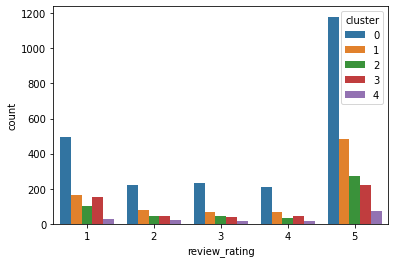

In [58]:
sns.countplot(data=aspectsdfclustered, x="review_rating",hue="cluster")


<AxesSubplot:xlabel='review_rating', ylabel='count'>

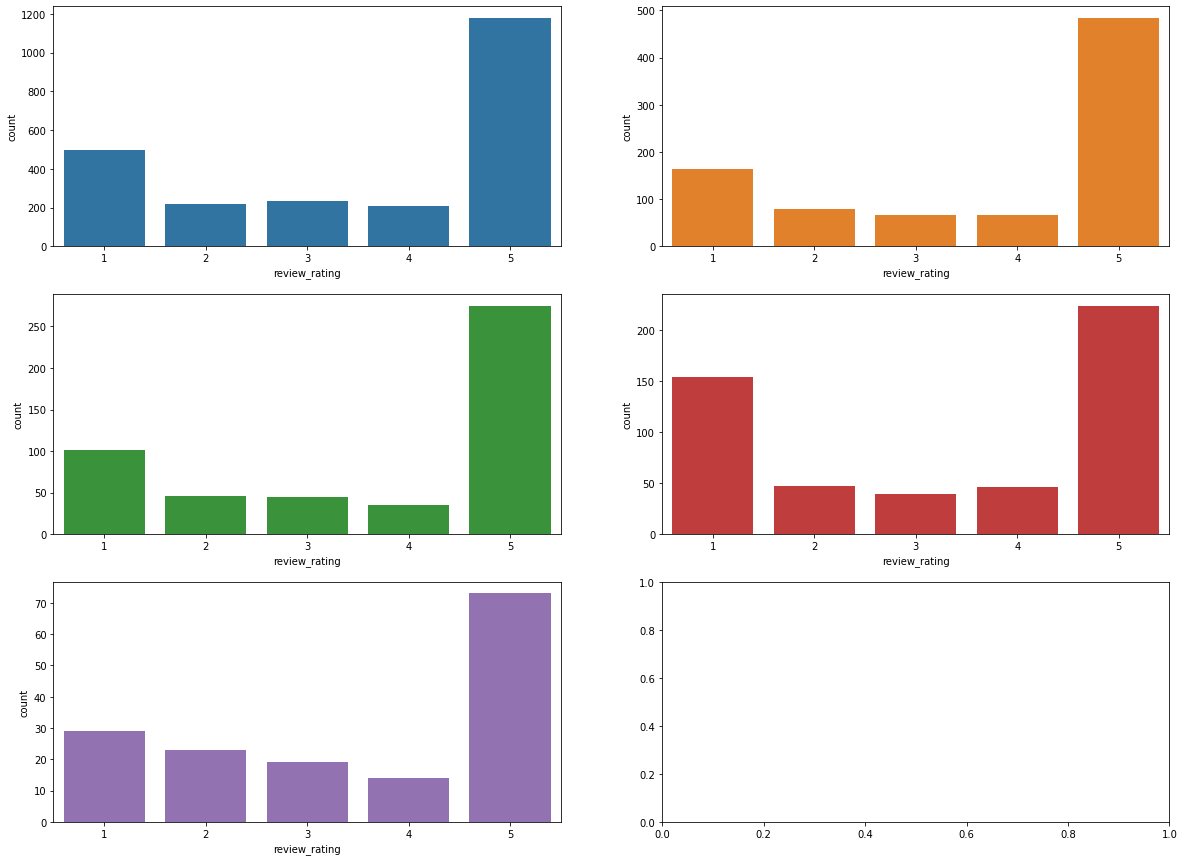

In [59]:
fig, axis = plt.subplots(3, 2, figsize=(20, 15))
sns.countplot(data=aspectsdfclustered.query(
    "cluster==0"), x="review_rating", ax=axis[0, 0], color=sns.color_palette()[0])
sns.countplot(data=aspectsdfclustered.query(
    "cluster==1"), x="review_rating", ax=axis[0, 1], color=sns.color_palette()[1])
sns.countplot(data=aspectsdfclustered.query(
    "cluster==2"), x="review_rating", ax=axis[1, 0], color=sns.color_palette()[2])
sns.countplot(data=aspectsdfclustered.query(
    "cluster==3"), x="review_rating", ax=axis[1, 1], color=sns.color_palette()[3])
sns.countplot(data=aspectsdfclustered.query(
    "cluster==4"), x="review_rating", ax=axis[2, 0], color=sns.color_palette()[4])


The rating distribution looks similar for different clusters, however cluster 0 and 3 have an excess of negative reviews.

In [60]:
aspectsdfclustered.columns

Index(['aspect', 'cluster', 'polarity', 'product_asin', 'product_name',
       'product_imageurl', 'product_price', 'product_global_rating',
       'review_amazonid', 'review_user', 'review_rating', 'review_title',
       'review_date', 'review_verified', 'review_content',
       'review_helpful_vote'],
      dtype='object')

How to name clusters

In [61]:
testcluster = aspectsdfclustered.query("cluster==0").copy()
name=aspectsdfclustered.query("cluster==0")[
    'aspect'].value_counts().first_valid_index()
print(name)
testcluster['aspect'].value_counts().nlargest(5)

strong


strong          90
love            61
great           59
disappointed    46
amazing         34
Name: aspect, dtype: int64

In [62]:
testcluster = aspectsdfclustered.query("cluster==1").copy()
name = aspectsdfclustered.query("cluster==1")[
    'aspect'].value_counts().first_valid_index()
print(name)
testcluster['aspect'].value_counts().nlargest(5)


scent


scent        426
smell        280
fragrance     41
aroma         17
fragrant       8
Name: aspect, dtype: int64

In [63]:
testcluster = aspectsdfclustered.query("cluster==2").copy()
name = aspectsdfclustered.query("cluster==2")[
    'aspect'].value_counts().first_valid_index()
print(name)
testcluster['aspect'].value_counts().nlargest(5)


candle


candle          352
wick             25
Candles          13
scent candle     13
wax              12
Name: aspect, dtype: int64

In [64]:
testcluster = aspectsdfclustered.query("cluster==3").copy()
name = aspectsdfclustered.query("cluster==3")[
    'aspect'].value_counts().first_valid_index()
print(name)
testcluster['aspect'].value_counts().nlargest(5)


buy


buy          90
purchase     40
price        39
worth        26
expensive    24
Name: aspect, dtype: int64

In [65]:
testcluster = aspectsdfclustered.query("cluster==4").copy()
name = aspectsdfclustered.query("cluster==4")[
    'aspect'].value_counts().first_valid_index()
print(name)
testcluster['aspect'].value_counts().nlargest(5)

burn


burn            141
burn hour         5
burn time         3
Burns             2
burn kitchen      1
Name: aspect, dtype: int64

In [66]:
cluster_names = {
    0: "Emotions", 
    1: "Scent",
    2: "Material", 
    3: "Price", 
    4: "Duration", 
    }

In [68]:
aspectsdfclustered["cluster_label"] = aspectsdfclustered["cluster"].map(cluster_names)

In [69]:
aspectsdfclustered["cluster_label"]

36322    Emotions
36323       Price
36323    Emotions
36324       Scent
36325    Emotions
           ...   
39486    Emotions
39488       Scent
39488    Emotions
39489    Emotions
39490    Emotions
Name: cluster_label, Length: 4367, dtype: object